In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [32]:
train_dataset = datasets.ImageFolder(root=os.path.join('tumor', 'Training'), transform=train_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join('tumor', 'Testing'), transform=valid_test_transforms)

valid_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - valid_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size], 
                                            generator=torch.Generator().manual_seed(42))

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [25]:
torch.cuda.is_available()

True

In [31]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)
    return precision, recall, f1, accuracy

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_running_loss = 0.0
    all_precision, all_recall, all_f1, all_accuracy = [], [], [], []
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            precision, recall, f1, accuracy = calculate_metrics(outputs, labels)
            
        val_running_loss += loss.item() * inputs.size(0)
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
        all_accuracy.append(accuracy)
    
    val_loss = val_running_loss / len(valid_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Precision: {np.mean(all_precision):.4f}, '
          f'Recall: {np.mean(all_recall):.4f}, '
          f'F1: {np.mean(all_f1):.4f}, '
          f'Accuracy: {np.mean(all_accuracy):.4f}')

Epoch 1/10, Loss: 0.4227, Val Loss: 0.4101, Precision: 0.7873, Recall: 0.9821, F1: 0.8713, Accuracy: 0.8469
Epoch 2/10, Loss: 0.2180, Val Loss: 0.1950, Precision: 0.9727, Recall: 0.9460, F1: 0.9588, Accuracy: 0.9563
Epoch 3/10, Loss: 0.1728, Val Loss: 0.1533, Precision: 0.9611, Recall: 0.9660, F1: 0.9630, Accuracy: 0.9609
Epoch 4/10, Loss: 0.1486, Val Loss: 0.1293, Precision: 0.9900, Recall: 0.9681, F1: 0.9786, Accuracy: 0.9781
Epoch 5/10, Loss: 0.1280, Val Loss: 0.1289, Precision: 0.9710, Recall: 0.9444, F1: 0.9571, Accuracy: 0.9563
Epoch 6/10, Loss: 0.1193, Val Loss: 0.1045, Precision: 0.9878, Recall: 0.9637, F1: 0.9752, Accuracy: 0.9734
Epoch 7/10, Loss: 0.1087, Val Loss: 0.1060, Precision: 0.9855, Recall: 0.9665, F1: 0.9755, Accuracy: 0.9750
Epoch 8/10, Loss: 0.1024, Val Loss: 0.0829, Precision: 0.9810, Recall: 0.9830, F1: 0.9817, Accuracy: 0.9812
Epoch 9/10, Loss: 0.0925, Val Loss: 0.0825, Precision: 0.9767, Recall: 0.9893, F1: 0.9828, Accuracy: 0.9812
Epoch 10/10, Loss: 0.0874, V

In [29]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_running_loss / len(test_loader.dataset)
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return test_loss, precision, recall, f1, accuracy, all_preds, all_labels

test_loss, precision, recall, f1, accuracy, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

print(f'''Test Loss: {test_loss:.4f}, 
      Precision: {precision:.4f}, 
      Recall: {recall:.4f}, 
      F1: {f1:.4f}, 
      Accuracy: {accuracy:.4f}''')

Test Loss: 0.0855, 
      Precision: 0.9825, 
      Recall: 0.9728, 
      F1: 0.9777, 
      Accuracy: 0.9745


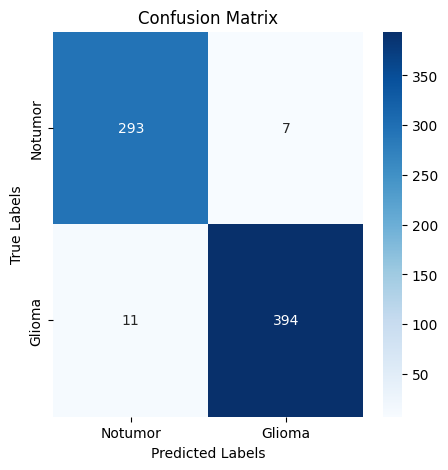

In [30]:
conf_matrix = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Notumor', 'Glioma'])
ax.yaxis.set_ticklabels(['Notumor', 'Glioma'])

plt.show()